# Heat Equation - with a larger mesh
### Sparse linear algebra

First import the required libraries for basic algebra and plotting. For larger problems, we use the scipy
sparse package, only storing non-zero entries in the LHS matrix.

In [1]:
from numpy import *
from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse.linalg import spsolve
set_printoptions(suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline

### Mesh

The mesh is made the same way as before.

In [2]:

# Make a rectangular mesh of triangles, nx by ny 
nx = 250
ny = 250

c = 0
geometry = zeros((nx*ny, 2), dtype='float')
for i in range(nx):
    for j in range(ny):
        geometry[c] = [float(i)/(nx-1), float(j)/(ny-1)]
        c += 1

ntri = (nx - 1)*(ny - 1)*2
topology = zeros((ntri, 3), dtype='int')

c = 0
for i in range(nx - 1):
    for j in range(ny - 1):
        ij = j + i*ny
        topology[c] = [ij, ij+ny, ij+ny+1]
        topology[c + 1] = [ij+1, ij, ij+ny+1]
        c += 2
        
mesh = (geometry, topology)

Here is a simple plotting routine to display the data values

In [3]:
def plot(mesh, data):
    geom, topo = mesh
    x = geom[:,0]
    y = geom[:,1]

    plt.gca(aspect='equal')
    plt.tricontourf(x, y, topo, data, 40)
        
    xmax = x.max()
    xmin = x.min()
    ymax = y.max()
    ymin = y.min()
    dx = 0.1*(xmax - xmin)
    dy = 0.1*(ymax - ymin)
    plt.xlim(xmin-dx, xmax+dx)
    plt.ylim(ymin-dy, ymax+dy)
    return


### Element matrix
The "element stiffness matrix", $K$ depends on the conductivity tensor $D$ and the triangle geometry.

$$ K_e = \int_{\Omega_e} B_e^T D B_e d\Omega $$


In [4]:
def Kmat(D, p, geometry):
    ''' Calculate K from the D matrix and the points '''
    # D contains the conductivity tensor
    # p contains the indices of the three points
    # making up the triangle
    assert(len(p) == 3)
    x0, y0 = geometry[p[0]]
    x1, y1 = geometry[p[1]]
    x2, y2 = geometry[p[2]]

    # Element area Ae
    Ae = 0.5*abs((x0 - x1)*(y2 - y1) - (y0 - y1)*(x2 - x1))

    # 'B' Matrix - representing the 'gradient' operator
    B = array([[y1 - y2, y2 - y0, y0 - y1],
               [x2 - x1, x0 - x2, x1 - x0]])/(2*Ae)

    K = Ae*matmul(B.transpose(), matmul(D, B))
    return K

### Matrix assembly (LHS)
The process of combining the local element matrices into a larger global matrix is called "assembly". It is really just a case of relabelling the indices with their global values, and adding the local matrices together. Now, we use the `scipy.sparse.lil_matrix` which only stores the non-zero entries.

In [5]:
def assemble_matrix(mesh, Dmat):
    geom, topo = mesh
    np = len(geom)
    Kglobal = lil_matrix((np, np))
    
    for tri in topo:
        K = Kmat(Dmat, tri, geom)
        for i, idx in enumerate(tri):
            for j, jdx in enumerate(tri):
                Kglobal[idx, jdx] += K[i, j]
    return Kglobal

In [6]:
Dmat = array([[15.0, 0.0],
              [0.0, 5.0]])

In [7]:
Kglobal = assemble_matrix(mesh, Dmat)

### RHS assembly

As before, we perform RHS assembly on the vector $f$, combining the local vector entries from each element. Each element has a constant source term $s$.


In [8]:
def fvec(s, p, geom):
    assert(len(p) == 3)
    x0, y0 = geometry[p[0]]
    x1, y1 = geometry[p[1]]
    x2, y2 = geometry[p[2]]

    # Element area Ae
    Ae = 0.5*abs((x0 - x1)*(y2 - y1) - (y0 - y1)*(x2 - x1))
    return s*Ae/3.0*ones(3)

def assemble_vector(mesh, s):
    geom, topo = mesh
    fg = zeros(len(geom))
    for tri in topo:
        f = fvec(s, tri, geom)
        for i, idx in enumerate(tri):
            fg[idx] += f[i]
    return fg

fglobal = assemble_vector(mesh, 3.0)

In [9]:
def set_bc(K, f, row, val):
    # Set BC
    K[row,:] = 0.0
    K[row, row] = 1.0
    f[row] = val

# Set zero BC on bottom edge
for i in range(nx):
    set_bc(Kglobal, fglobal, i*ny, 0.0)

# Set u=10 BC on left edge
for j in range(ny):
    y = (j/(ny+1))
    set_bc(Kglobal, fglobal, j, 0.04*sin(2*pi*y))


Finally, we can refer the $K.u = f$ problem to a sparse linear algebra solver which will use an LU method to get the answer. The solver requires the matrix in CSR format. 

In [10]:
u = spsolve(Kglobal.tocsr(), fglobal)
print(u.max(), u.min())
print('Number of DOFS=', len(u))

0.07354042572683187 -0.039999216713052996
Number of DOFS= 62500


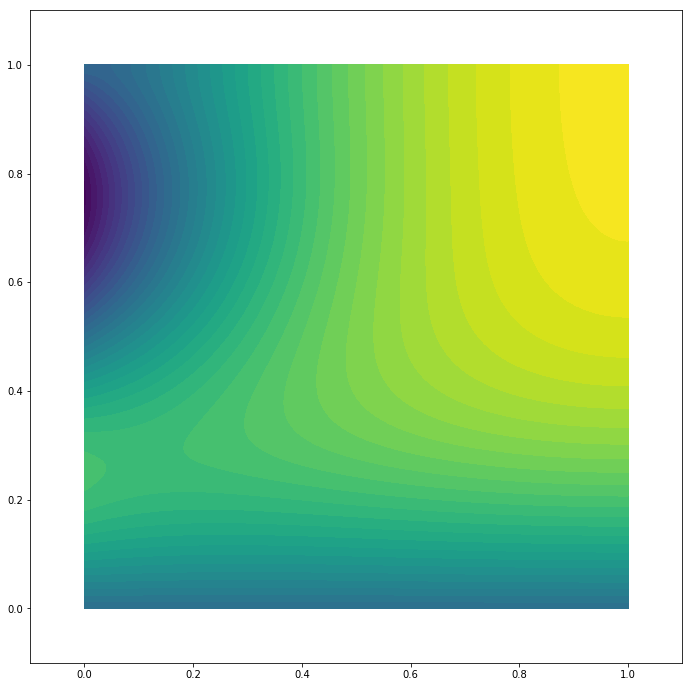

In [11]:
plt.figure(figsize=(12,12))
plot(mesh, u)